In [1]:
!pip install git+https://github.com/Farama-Foundation/MAgent2
!git clone https://github.com/giangbang/RL-final-project-AIT-3007.git

  Cloning https://github.com/Farama-Foundation/MAgent2 to /tmp/pip-req-build-34042phh
  Running command git clone --filter=blob:none --quiet https://github.com/Farama-Foundation/MAgent2 /tmp/pip-req-build-34042phh
  Resolved https://github.com/Farama-Foundation/MAgent2 to commit b2ddd49445368cf85d4d4e1edcddae2e28aa1406
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 53.0 MB/s eta 0:00:00
  Created wheel for magent2: filename=magent2-0.3.3-cp310-cp310-linux_x86_64.whl size=1696073 sha256=a73ae9c9bf07920297e029396204fe1857e0a419dbf701ba861734dd998699ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-jbej7tyt/wheels/e4/8e/bf/51a30bc4038546e23b81c9fb513fe6a8fd916e5a9c5f4291d5
Successfully built magent2
Cloning into 'RL-final-project-AIT-3007'...
remote: Enumerating

In [2]:
import sys
sys.path.append('RL-final-project-AIT-3007')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque, Counter
import os
from magent2.environments import battle_v4
import time

# 1. Khởi tạo Replay Buffer
Được dùng để lưu trữ các dữ liệu về state, action, reward, next_state và các ván đấu trước đã hoàn thành hay chưa?

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, index):
        return self.buffer[index]

In [5]:
class QNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], 8, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
        )

        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]

        self.fc = nn.Sequential(
            nn.Linear(flatten_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, action_shape)
        )

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        out = self.cnn(x)

        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]

        out = out.reshape(batchsize, -1)
        return self.fc(out)

In [22]:
class Trainer:
    def __init__(self, env, config_qnet=None, input_shape=None, action_shape=None, learning_rate=1e-3):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = QNetwork(input_shape, action_shape).to(self.device)
        self.target_network = QNetwork(input_shape, action_shape).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        # self.optimizer = optim.SGD(self.q_network.parameters(), lr=learning_rate)
        self.steplr = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=1, gamma=0.9)
        self.replay_buffer = ReplayBuffer(capacity=60000)

        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.97
        self.update_target_every = 3

        # Log to store training metrics
        self.log = []

    def select_action(self, observation, agent):
        """
        Select action based on epsilon-greedy policy with potential softmax exploration.
        """
        # If epsilon is greater than a random value, select a random action
        if np.random.rand() <= self.epsilon:
            return self.env.action_space(agent).sample()

        observation = torch.FloatTensor(observation).unsqueeze(0).to(self.device)

        with torch.no_grad():  # Inference mode, no gradient computation
            q_values = self.q_network(observation)

        # If we want exploration based on softmax (epsilon is scaled down)
        if np.random.rand() <= self.epsilon * 0.1:
            exp_q_values = torch.exp(q_values).cpu().numpy().flatten()
            action_probabilities = exp_q_values / exp_q_values.sum()  # Normalize
            return np.random.choice(len(action_probabilities), p=action_probabilities)

        return torch.argmax(q_values, dim=1).item()

    def training(self, episodes=100, batch_size=1024):
        for episode in range(episodes):
            self.env.reset()
            total_reward = 0
            reward_for_agent = {agent: 0 for agent in self.env.agents if agent.startswith('blue')}
            prev_observation = {}
            prev_action = {}
            step = 0

            for idx, agent in enumerate(self.env.agent_iter()):
                step += 1
                observation, reward, termination, truncation, info = self.env.last()
                observation = np.transpose(observation, (2, 0, 1))

                agent_handle = agent.split('_')[0]

                if agent_handle == 'blue':
                    total_reward += reward
                    reward_for_agent[agent] += reward

                if termination or truncation:
                    action = None
                else:
                    if agent_handle == 'blue':
                        action = self.select_action(observation, agent)
                    else:
                        action = self.env.action_space(agent).sample()

                if agent_handle == 'blue':
                    if agent in prev_observation and agent in prev_action:
                        self.replay_buffer.add(
                            prev_observation[agent],
                            prev_action[agent],
                            reward,
                            observation,
                            termination
                        )

                    prev_observation[agent] = observation
                    prev_action[agent] = action

                self.env.step(action)

            # If replay buffer has enough data, train the model
            if len(self.replay_buffer) >= batch_size:
                dataloader = DataLoader(self.replay_buffer, batch_size=batch_size, shuffle=True, drop_last=True)
                self.update_model(dataloader)

            # Update target network periodically
            if (episode + 1) % self.update_target_every == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())
                self.steplr.step()

            max_reward = max(reward_for_agent.values())

            # Log metrics
            self.log.append({
                "Episode": episode + 1,
                "Epsilon": self.epsilon,
                "Total Reward": total_reward,
                "Steps": step,
                "Max Reward": max_reward,
                "Learning Rate": self.steplr.get_last_lr()[0]
            })

            print(f"Episode {episode + 1}, Epsilon: {self.epsilon:.2f}, Total Reward: {total_reward}, Steps: {step}, Max Reward: {max_reward}, lr: {self.steplr.get_last_lr()}")

            # Decay epsilon to reduce exploration over time
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def update_model(self, dataloader):
        self.q_network.train()
        for states, actions, rewards, next_states, dones in dataloader:
            # Move tensors to the correct device
            states = states.to(dtype=torch.float32, device=self.device)
            actions = actions.to(dtype=torch.long, device=self.device)
            rewards = rewards.to(dtype=torch.float32, device=self.device)
            next_states = next_states.to(dtype=torch.float32, device=self.device)
            dones = dones.to(dtype=torch.float32, device=self.device)

            # Current Q-values
            current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

            # Next Q-values using Double Q-Learning
            with torch.no_grad():
                next_actions = self.q_network(next_states).argmax(1)
                next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)

            # Calculate expected Q-values
            expected_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

            # Compute loss and update model
            loss = self.criterion(current_q_values, expected_q_values)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def plot_training_log(self):
        if not self.log:
            print("Ko có dữ liệu")
            return

        episodes = [entry["Episode"] for entry in self.log]
        epsilons = [entry["Epsilon"] for entry in self.log]
        total_rewards = [entry["Total Reward"] for entry in self.log]
        steps = [entry["Steps"] for entry in self.log]
        max_rewards = [entry["Max Reward"] for entry in self.log]
        learning_rates = [entry["Learning Rate"] for entry in self.log]

        plt.figure(figsize=(12, 8))

        # Plot Total Reward
        plt.subplot(2, 3, 1)
        plt.plot(episodes, total_rewards, label="Total Reward", color="blue")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.title("Total Reward per Episode")
        plt.grid()
        plt.legend()

        # Plot Epsilon
        plt.subplot(2, 3, 2)
        plt.plot(episodes, epsilons, label="Epsilon", color="orange")
        plt.xlabel("Episodes")
        plt.ylabel("Epsilon")
        plt.title("Epsilon Decay")
        plt.grid()
        plt.legend()

        # Plot Steps
        plt.subplot(2, 3, 3)
        plt.plot(episodes, steps, label="Steps", color="green")
        plt.xlabel("Episodes")
        plt.ylabel("Steps")
        plt.title("Steps per Episode")
        plt.grid()
        plt.legend()

        # Plot Max Reward
        plt.subplot(2, 3, 4)
        plt.plot(episodes, max_rewards, label="Max Reward", color="purple")
        plt.xlabel("Episodes")
        plt.ylabel("Max Reward")
        plt.title("Max Reward per Episode")
        plt.grid()
        plt.legend()

        # Plot Learning Rate
        plt.subplot(2, 3, 5)
        plt.plot(episodes, learning_rates, label="Learning Rate", color="red")
        plt.xlabel("Episodes")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Decay")
        plt.grid()
        plt.legend()

        plt.tight_layout()
        plt.show()


In [23]:
env = battle_v4.env(map_size=45, render_mode=None)

trainer = Trainer(env, input_shape=env.observation_space("red_0").shape, action_shape=env.action_space("red_0").n)
trainer.training()

Episode 1, Epsilon: 1.00, Total Reward: -3189.375116556883, Steps: 159746, Max Reward: -4.080000156536698, lr: [0.001]
Episode 2, Epsilon: 0.97, Total Reward: -3206.7351157851517, Steps: 160207, Max Reward: -15.885000579990447, lr: [0.001]
Episode 3, Epsilon: 0.94, Total Reward: -3189.900114557706, Steps: 159926, Max Reward: -33.10000134911388, lr: [0.0009000000000000001]
Episode 4, Epsilon: 0.91, Total Reward: -2929.7451064279303, Steps: 158620, Max Reward: -6.275000241585076, lr: [0.0009000000000000001]
Episode 5, Epsilon: 0.89, Total Reward: -2925.5801042262465, Steps: 158633, Max Reward: -5.6350002167746425, lr: [0.0009000000000000001]
Episode 6, Epsilon: 0.86, Total Reward: -2845.985101413913, Steps: 158841, Max Reward: -6.730000247247517, lr: [0.0008100000000000001]
Episode 7, Epsilon: 0.83, Total Reward: -2936.8001022506505, Steps: 161277, Max Reward: -28.30000135023147, lr: [0.0008100000000000001]
Episode 8, Epsilon: 0.81, Total Reward: -2852.7000995753333, Steps: 159580, Max R

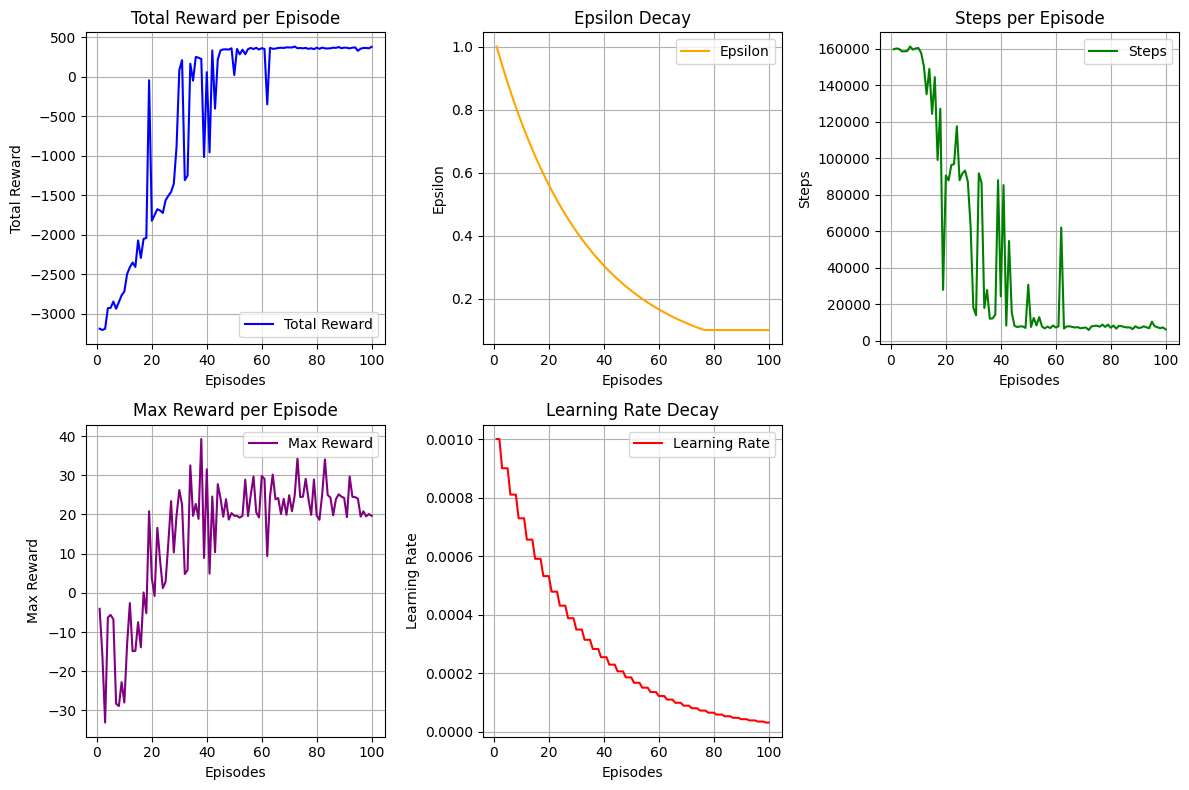

In [24]:
trainer.plot_training_log()

In [28]:
os.makedirs("RL-final-project-AIT-3007", exist_ok=True)
torch.save(trainer.q_network.state_dict(), "RL-final-project-AIT-3007/final_blue.pt")
print("Training complete. Model saved.")

Training complete. Model saved.


In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [30]:
import final_torch_model
import torch_model

# from torch_model import QNetwork
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, *args, **kwargs: x  # Fallback: tqdm becomes a no-op

def eval():
    max_cycles = 300
    env = battle_v4.env(map_size=45, max_cycles=max_cycles)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    ### Load network
    Network = QNetwork(observation_shape=env.observation_space("red_0").shape, action_shape=env.action_space("red_0").n)
    Network.load_state_dict(
        torch.load(
            "RL-final-project-AIT-3007/final_blue.pt",
            weights_only=True,
            map_location=device
        )
    )
    Network.to(device)

    ### Load red_final model
    red_final_network = final_torch_model.QNetwork(
        env.observation_space("red_0").shape, env.action_space("red_0").n
    )
    red_final_network.load_state_dict(
        torch.load(
            "RL-final-project-AIT-3007/red_final.pt",
            weights_only=True,
            map_location=device
        )
    )
    red_final_network = red_final_network.to(device)

    ### Load red model
    red_network = torch_model.QNetwork(
        env.observation_space("red_0").shape, env.action_space("red_0").n
    )
    red_network.load_state_dict(
        torch.load(
            "RL-final-project-AIT-3007/red.pt",
            weights_only=True,
            map_location=device
        )
    )
    red_network = red_network.to(device)

    def random_policy(env, agent, obs):
        return env.action_space(agent).sample()

    def red_final_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        red_final_network.eval()
        with torch.inference_mode():
            q_values = red_final_network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

    def red_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        red_network.eval()
        with torch.inference_mode():
            q_values = red_network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

    def policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        Network.eval()
        with torch.inference_mode():
            q_values = Network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

    # def policy()

    def run_eval(env, red_policy, blue_policy, n_episode: int = 100):
        red_win, blue_win = [], []
        red_tot_rw, blue_tot_rw = [], []
        n_agent_each_team = len(env.env.action_spaces) // 2

        for _ in tqdm(range(n_episode)):
            env.reset()
            n_kill = {"red": 0, "blue": 0}
            red_reward, blue_reward = 0, 0

            for agent in env.agent_iter():
                observation, reward, termination, truncation, info = env.last()
                agent_team = agent.split("_")[0]

                n_kill[agent_team] += (
                    reward > 4.5
                )  # This assumes default reward settups
                if agent_team == "red":
                    red_reward += reward
                else:
                    blue_reward += reward

                if termination or truncation:
                    action = None  # this agent has died
                else:
                    if agent_team == "red":
                        action = red_policy(env, agent, observation)
                    else:
                        action = blue_policy(env, agent, observation)

                env.step(action)

            who_wins = "red" if n_kill["red"] >= n_kill["blue"] + 5 else "draw"
            who_wins = "blue" if n_kill["red"] + 5 <= n_kill["blue"] else who_wins
            red_win.append(who_wins == "red")
            blue_win.append(who_wins == "blue")

            red_tot_rw.append(red_reward / n_agent_each_team)
            blue_tot_rw.append(blue_reward / n_agent_each_team)

        return {
            "winrate_red": np.mean(red_win),
            "winrate_blue": np.mean(blue_win),
            "average_rewards_red": np.mean(red_tot_rw),
            "average_rewards_blue": np.mean(blue_tot_rw),
        }

    print("=" * 20)
    print("Eval with red final policy")
    print(
        run_eval(
            env=env, red_policy=red_final_policy, blue_policy=policy, n_episode=30
        )
    )

    print("=" * 20)
    print("Eval with red policy")
    print(
        run_eval(
            env=env, red_policy=red_policy, blue_policy=policy, n_episode=30
        )
    )

    print("=" * 20)
    print("Eval with random policy")
    print(
        run_eval(
            env=env, red_policy=random_policy, blue_policy=policy, n_episode=30
        )
    )

    print("=" * 20)

if __name__ == "__main__":
    eval()

Eval with red final policy


100%|██████████| 30/30 [02:51<00:00,  5.71s/it]


{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': 1.8971728241833792, 'average_rewards_blue': 4.8008477166532675}
Eval with red policy


100%|██████████| 30/30 [01:27<00:00,  2.92s/it]


{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': 0.17001851644604601, 'average_rewards_blue': 5.058781866320705}
Eval with random policy


100%|██████████| 30/30 [01:40<00:00,  3.36s/it]

{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': -1.0186749331856246, 'average_rewards_blue': 4.886002031238864}
